In [2]:
# General data manipulation
import pandas
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import pandas as pd
from PIL import Image # pip install pillow
import gc
import os
from os import listdir
from os.path import isfile, join
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# if os.getcwd() != '/home/azureuser/IDAO_2021':
#     os.chdir('/home/azureuser/IDAO_2021')

In [48]:
DIR = os.getcwd() + '/idao_dataset'
# get train file names and convert to dataframe
# you may need to change your working directory first:
# os.chdir('/your_path')
ER_file_names = os.listdir(DIR + '/train/ER/')
NR_file_names = os.listdir(DIR + '/train/NR/')

ER = pd.DataFrame([[y.replace(';1.png','').replace('ev','') for y in x.split('_')] + [x] for x in ER_file_names])
NR = pd.DataFrame([[y.replace(';1.png','').replace('ev','') for y in x.split('_')] + [x] for x in NR_file_names])

# only few columns have distinct values
# print(ER.apply(lambda x: len(x.unique())))
# print(NR.apply(lambda x: len(x.unique())))

ER = ER[[5,6,0,15,16,17]].rename(columns={5:'type',6:'energy',0:'num',15:'run',16:'ev',17:'path'})
NR = NR[[6,7,0,17,18,19]].rename(columns={6:'type',7:'energy',0:'num',17:'run',18:'ev',19:'path'})
data = ER.append(NR, ignore_index=True)
data = data.astype(dict(zip(data.columns,[str,int,float,str,int,str])))
data['type_2'] = (data.type == 'ER')*1
data.head()

,type,energy,num,run,ev,path,type_2
0,ER,30,0.502326,run4,494,0.5023260116577148__CYGNO_60_40_ER_30_keV_930V...,1
1,ER,3,-0.423183,run5,229,-0.42318278551101685__CYGNO_60_40_ER_3_keV_930...,1
2,ER,3,-0.493629,run2,333,-0.4936290979385376__CYGNO_60_40_ER_3_keV_930V...,1
3,ER,30,-1.189218,run2,288,-1.189218282699585__CYGNO_60_40_ER_30_keV_930V...,1
4,ER,10,1.117318,run2,299,1.117317795753479__CYGNO_60_40_ER_10_keV_930V_...,1


In [49]:
data.groupby(['type','energy']).count()

num   run    ev  path  type_2
type energy                                
ER   1          3     3     3     3       3
     3       2243  2243  2243  2243    2243
     6          1     1     1     1       1
     10      2272  2272  2272  2272    2272
     20         2     2     2     2       2
     30      2237  2237  2237  2237    2237
NR   1       2177  2177  2177  2177    2177
     3          2     2     2     2       2
     6       2255  2255  2255  2255    2255
     10         2     2     2     2       2
     20      2208  2208  2208  2208    2208
     30         2     2     2     2       2

In [4]:
# convert PIL.Image object to numpy.Array, for training
def img2arr(img):
    return np.asarray(img.getdata(), dtype=np.uint8).reshape(img.height, img.width, -1)

def read_train_pickle(Type, Energy, DIR = os.getcwd() + '/idao_dataset/'):
    return pd.read_pickle(DIR + 'train_pickle/' + Type + str(Energy) + '.pkl')

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 19 08:20:58 2018

@OS: Ubuntu 18.04
@IDE: Spyder3
@author: Aldi Faizal Dimara (Steam ID: phenomos)
"""

import keras.backend as K
import tensorflow as tf

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha_t*((1-p_t)^gamma)*log(p_t)
        
        p_t = y_pred, if y_true = 1
        p_t = 1-y_pred, otherwise
        
        alpha_t = alpha, if y_true=1
        alpha_t = 1-alpha, otherwise
        
        cross_entropy = -log(p_t)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true)*alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1-p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss    

Using TensorFlow backend.
/Users/joefu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/joefu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/joefu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/joefu/opt/anaconda3/lib/python3.7/sit

In [6]:
N = 2000
training_data = pd.DataFrame()
loss_weights = []

in_sample = {'ER': [3,10,30], 'NR': [1,6,20]}
for Type in in_sample:
    for Energy in in_sample[Type]:
        if Energy >= 20 or Energy <= 3:
            continue
        pkl = read_train_pickle(Type, Energy)
        pkl['isTrain'] = 1
        training_data = training_data.append(pkl[:N])

out_sample = {'NR': [3,10,30], 'ER': [1,6,20]}
for Type in out_sample:
    for Energy in out_sample[Type]:
        if Energy >= 20 or Energy <= 3:
            continue
        pkl = read_train_pickle(Type, Energy)[:1]
        pkl = pd.concat([pkl]*8)
        pkl = pkl.reset_index(drop = True)
        pkl.loc[1,'img_array'] = [np.rot90(pkl.loc[1,'img_array'], k = 1)]
        pkl.loc[2,'img_array'] = [np.rot90(pkl.loc[2,'img_array'], k = 2)]
        pkl.loc[3,'img_array'] = [np.rot90(pkl.loc[3,'img_array'], k = 3)]
        pkl.loc[4,'img_array'] = [np.flip(pkl.loc[4,'img_array'], axis = 0)]
        pkl.loc[5,'img_array'] = [np.flip(pkl.loc[5,'img_array'], axis = 1)]
        pkl.loc[6,'img_array'] = [np.transpose(pkl.loc[6,'img_array'])]
        pkl.loc[7,'img_array'] = [np.flip(np.transpose(np.flip(pkl.loc[7,'img_array'], axis=1)), axis=1)]
        pkl['isTrain'] = 0
        training_data = training_data.append(pkl)
            
# training_data = training_data.loc[training_data.type_2_ER==1]
# training_data = training_data.sample(frac=1).reset_index(drop=True)
training_data = training_data.reset_index(drop=True)
training_data.head()

,img_array,type_2_ER,energy,isTrain
0,"[[101, 97, 100, 99, 100, 101, 94, 97, 99, 101,...",1,10,1
1,"[[100, 91, 101, 101, 101, 97, 100, 101, 103, 1...",1,10,1
2,"[[104, 100, 101, 102, 103, 99, 104, 101, 98, 9...",1,10,1
3,"[[97, 91, 100, 103, 101, 102, 95, 104, 98, 102...",1,10,1
4,"[[102, 102, 97, 98, 96, 100, 102, 104, 98, 103...",1,10,1


In [7]:
from scipy.ndimage import *
k = 64
img_arr_list = []
for i in range(len(training_data)):
    img = training_data.loc[i,'img_array']
    img = img[(288-k):(288+k), (288-k):(288+k)].astype(float)
    img -= np.median(img, axis=0)
    img = grey_closing(gaussian_gradient_magnitude(img,5), 9)
    img_arr_list.append(img)

In [8]:
img_array = np.array(img_arr_list).reshape(len(img_arr_list),k*2,k*2,1)
img_array.shape

(4016, 128, 128, 1)

In [9]:
training_data['type_str'] = [('ER' if training_data.type_2_ER[i] else 'NR') + str(training_data.energy[i]) for i in range(len(training_data))]
training_data['type_i'] = [(training_data.type_2_ER[i])*2 + (training_data.energy[i]==10) for i in range(len(training_data))]
# NR1 NR3 ER1 ER3
# NR6 NR10 ER6 ER10
# NR20 NR30 ER20 ER30
target_data = [[0]*4 for _ in range(len(training_data))]
for i in range(len(target_data)):
    target_data[i][training_data.type_i[i]] = 1
target_data = np.array(target_data)

In [10]:
target_data

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [11]:
training_data

,img_array,type_2_ER,energy,isTrain,type_str,type_i
0,"[[101, 97, 100, 99, 100, 101, 94, 97, 99, 101,...",1,10,1,ER10,3
1,"[[100, 91, 101, 101, 101, 97, 100, 101, 103, 1...",1,10,1,ER10,3
2,"[[104, 100, 101, 102, 103, 99, 104, 101, 98, 9...",1,10,1,ER10,3
3,"[[97, 91, 100, 103, 101, 102, 95, 104, 98, 102...",1,10,1,ER10,3
4,"[[102, 102, 97, 98, 96, 100, 102, 104, 98, 103...",1,10,1,ER10,3
...,...,...,...,...,...,...
4011,"[[102, 99, 99, 104, 101, 100, 101, 97, 102, 10...",1,6,0,ER6,2
4012,"[[102, 106, 98, 102, 98, 101, 101, 98, 100, 98...",1,6,0,ER6,2
4013,"[[105, 102, 102, 100, 101, 99, 97, 102, 102, 9...",1,6,0,ER6,2
4014,"[[100, 99, 97, 98, 102, 94, 99, 99, 98, 100, 1...",1,6,0,ER6,2


In [12]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, AveragePooling2D
from random import random as rng

x_train = img_array[::2]
x_test = img_array[1::2]
y_train = target_data[::2]
y_test = target_data[1::2]

inputA = Input(shape=(k*2,k*2,1))
inputB = Input(shape=(1,))
# the first branch operates on the first input
x = Conv2D(4, kernel_size=9, activation='relu', input_shape=(k*2,k*2,1))(inputA)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(8, kernel_size=5, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(16, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Model(inputs=inputA, outputs=x)

y = Model(inputs=inputB, outputs=inputB)
combined = concatenate([x.output, y.output])
z = Dense(128, activation='linear')(combined)
# z = Dense(1, activation='sigmoid')(z)
z = Dense(4, activation='softmax')(z)

model_1 = Model(inputs=[x.input, y.input], outputs=z)
model_1.compile(loss=categorical_focal_loss(gamma=4.0, alpha=1),
# model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [32]:
cnn_1 = model_1.fit([x_train, training_data.isTrain[::2]], y_train,
          batch_size=251, epochs=2,
#           batch_size=50, epochs=5,
          # verbose=1,
          validation_data=([x_test,training_data.isTrain[1::2]], y_test))

# cnn_1 = model_1.fit(x_train, y_train,
#           batch_size=753, epochs=5,
#           # verbose=1,
#           validation_data=(x_test, y_test))

Train on 2008 samples, validate on 2008 samples
Epoch 1/2
2008/2008 [==============================] - 19s 9ms/step - loss: 4.0216e-04 - accuracy: 0.9995 - val_loss: 5.5305e-04 - val_accuracy: 0.9980
Epoch 2/2
2008/2008 [==============================] - 19s 9ms/step - loss: 2.4143e-04 - accuracy: 1.0000 - val_loss: 5.3974e-04 - val_accuracy: 0.9985


In [15]:
# from keras.utils import plot_model
# plot_model(model_1, show_shapes=True)

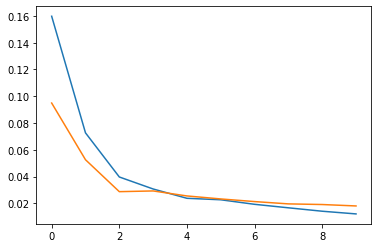

In [45]:
plt.plot(cnn_1.history['loss'])
plt.plot(cnn_1.history['val_loss'])

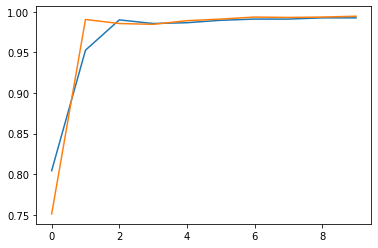

In [46]:
plt.plot(cnn_1.history['accuracy'])
plt.plot(cnn_1.history['val_accuracy'])

In [36]:
model_1.save('Joe_model_Energy_6vs10_01.h5')

In [38]:
from keras.models import load_model
model_1 = load_model('Joe_model_Energy_6vs10_01.h5', custom_objects={'focal_loss': categorical_focal_loss(gamma=5.0,alpha=1.0)})

In [43]:
in_sample = {'ER': [3,10,30], 'NR': [1,6,20]}
predicts_in = pd.DataFrame()
for Type in in_sample:
    for Energy in in_sample[Type]:
        if Energy >= 20 or Energy <= 3:
            continue
        pkl = read_train_pickle(Type, Energy)
        predicts_in = predicts_in.append(pkl)
predicts_in = predicts_in.reset_index(drop=True)

from scipy.ndimage import gaussian_gradient_magnitude, grey_closing
k = 64
img_arr_in = []
for i in range(len(predicts_in)):
    img = predicts_in.loc[i,'img_array']
    img = img[(288-k):(288+k), (288-k):(288+k)].astype(float)
    img -= np.median(img, axis=0)
    img = grey_closing(gaussian_gradient_magnitude(img,5), 9)
    img_arr_in.append(img)
img_arr_in = np.array(img_arr_in).reshape((len(predicts_in),k*2,k*2,1))
img_arr_in.shape

(4527, 128, 128, 1)

In [44]:
predicts_in['isTrain'] = 1
predicts_in['type_i'] = [(predicts_in.type_2_ER[i])*2 + (predicts_in.energy[i]==10) for i in range(len(predicts_in))]
y_pred = model_1.predict([img_arr_in, np.array([1]*len(predicts_in)).reshape((len(predicts_in),1))])
for i in range(len(predicts_in)):
    if predicts_in.isTrain[i] == 0:
        y_pred[i][0] = 0
        y_pred[i][3] = 0
predicts_in['pre_i'] = np.argmax(y_pred, axis=-1)

In [45]:
predicts_in['correct'] = predicts_in.pre_i == predicts_in.type_i
print(sum(predicts_in.correct)/len(predicts_in))

1.0


In [46]:
predicts_in[predicts_in.correct != True]

,img_array,type_2_ER,energy,isTrain,type_i,pre_i,correct


In [95]:
y_pred[predicts_in.correct != True].round(3)

array([[0.508, 0.423, 0.   , 0.069]], dtype=float32)

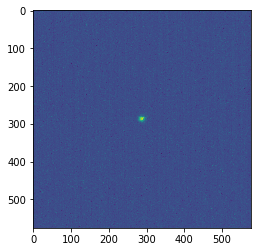

In [96]:
plt.imshow(predicts_in[predicts_in.correct != True].loc[893,'img_array'])

In [15]:
out_sample = {'NR': [3,10,30], 'ER': [1,6,20]}
predicts_out = pd.DataFrame()
for Type in out_sample:
    for Energy in out_sample[Type]:
        if Energy >= 20 or Energy <= 3:
            continue
        pkl = read_train_pickle(Type, Energy)
        pkl['isTrain'] = 0
        predicts_out = predicts_out.append(pkl)
        
predicts_out = predicts_out.reset_index(drop=True)
from scipy.ndimage import gaussian_gradient_magnitude, grey_closing

img_arr_out = []
for i in range(len(predicts_out)):
    img = predicts_out.loc[i,'img_array']
    img = img[(288-k):(288+k), (288-k):(288+k)].astype(float)
    img -= np.median(img, axis=0)
    img = grey_closing(gaussian_gradient_magnitude(img,5), 9)
    img_arr_out.append(img)
img_arr_out = np.array(img_arr_out).reshape((len(predicts_out),k*2,k*2,1))
img_arr_out.shape

(3, 128, 128, 1)

In [39]:
predicts_out['type_i'] = [(predicts_out.type_2_ER[i])*2 + (predicts_out.energy[i]==10) for i in range(len(predicts_out))]
y_pred = model_1.predict([img_arr_out, np.array([0]*12).reshape((12,1))])
for i in range(len(predicts_out)):
    if predicts_out.isTrain[i] == 0:
        y_pred[i][0] = 0
        y_pred[i][3] = 0
predicts_out['pre_i'] = np.argmax(y_pred, axis=-1)

In [40]:
predicts_out

,img_array,type_2_ER,energy,isTrain,type_i,pre_i
0,"[[102, 95, 101, 105, 99, 97, 95, 98, 97, 99, 1...",0,10,0,1,1
1,"[[99, 99, 99, 101, 101, 101, 98, 102, 102, 99,...",0,10,0,1,1
2,"[[100, 104, 100, 101, 99, 106, 103, 99, 101, 1...",1,6,0,2,2


In [41]:
y_pred.round(3)

array([[0.   , 0.52 , 0.214, 0.   ],
       [0.   , 0.449, 0.247, 0.   ],
       [0.   , 0.255, 0.528, 0.   ]], dtype=float32)

In [42]:
y_pred.round(3)

array([[0.   , 0.52 , 0.214, 0.   ],
       [0.   , 0.449, 0.247, 0.   ],
       [0.   , 0.255, 0.528, 0.   ]], dtype=float32)